In [68]:
import numpy as np
import flow
import os
import tensortools as tt
import cascade as cas
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
from munkres import Munkres
from scipy import linalg

done.
done.
done.
done.
done.


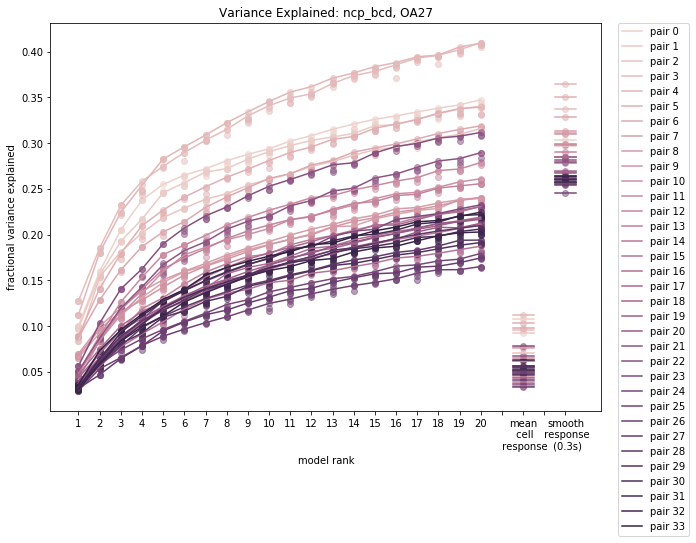

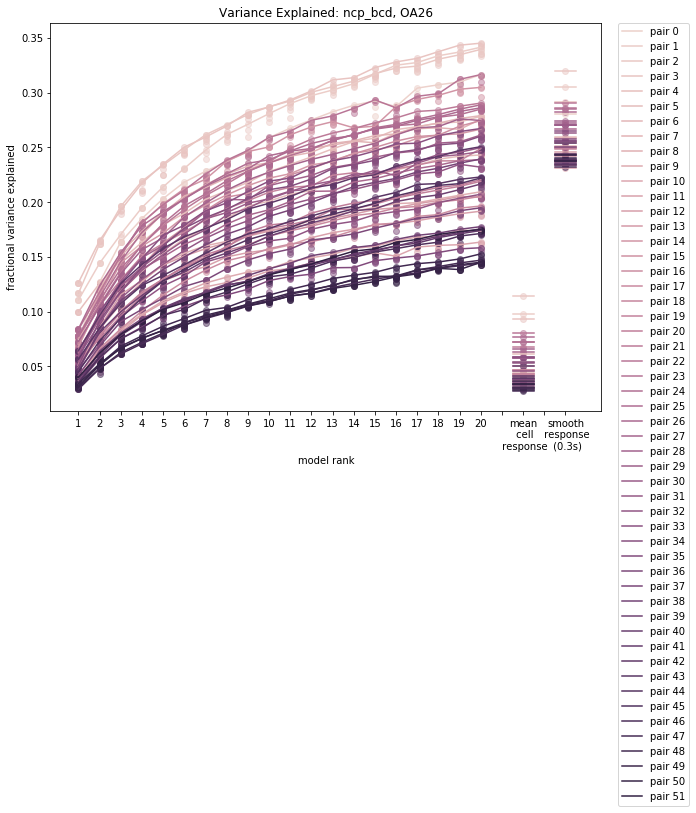

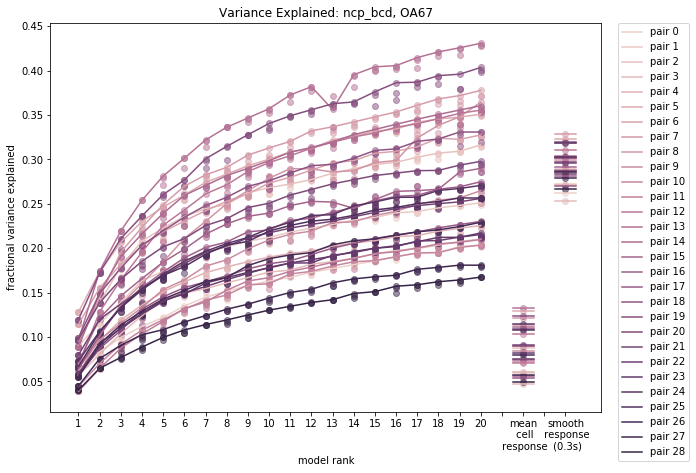

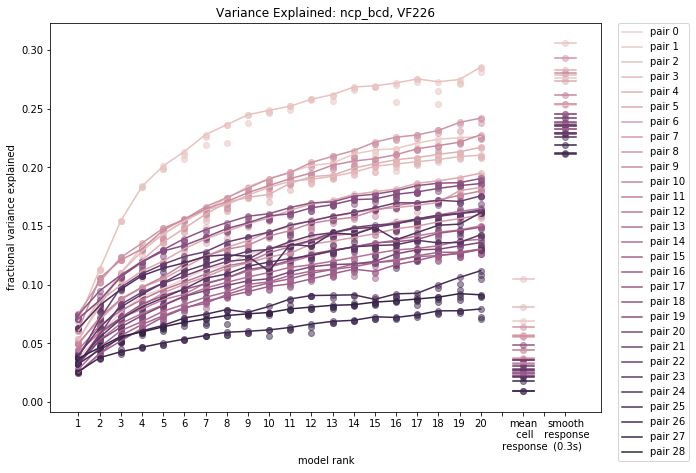

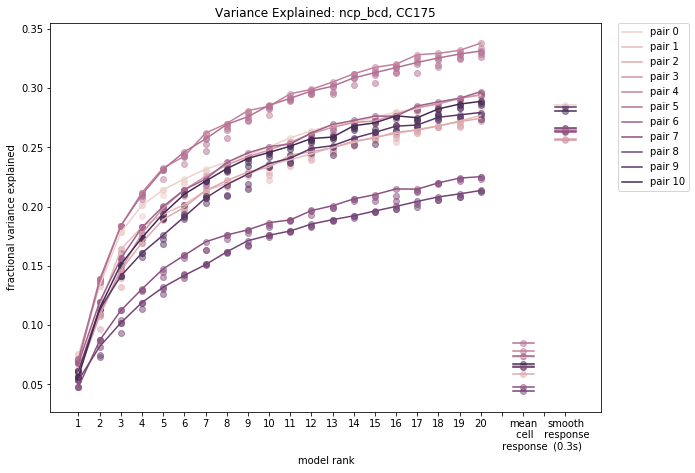

In [116]:
for mouse in ['OA27', 'OA26', 'OA67', 'VF226', 'CC175']:
    # mouse = 'OA27'
    trace_type = 'zscore'
    days = flow.metadata.DateSorter.frommeta(mice=[mouse], tags=None)
    m = 'ncp_bcd'
    
    cmap = sns.color_palette(sns.cubehelix_palette(len(days)))
#     cmap = sns.color_palette('hls', n_colors=len(days))
#     dmap = sns.hls_palette(len(days), l=.3, s=.8)

    # create figure and axes
    buffer = 5
    right_pad = 5
    # fig = plt.figure(figsize=(24,6))
    fig = plt.figure(figsize=(10,8))
    gs = GridSpec(100, 100, figure=fig, left=0.05, right=.95, top=.95, bottom=0.05)
    ax = fig.add_subplot(gs[10:90-buffer, :90-right_pad])
    # ax = fig.add_subplot(gs[10:90-buffer, :30-right_pad])
    # ax1 = fig.add_subplot(gs[10:90-buffer, 30:60-right_pad])
    # ax2 = fig.add_subplot(gs[10:90-buffer, 60:90-right_pad])

    for c, day1 in enumerate(days, 0):
        try:
            day2 = days[c+1]
        except IndexError:
            print('done.')
            break

        # create folder structure if needed
        # load
        out_dir = os.path.join(flow.paths.outd, str(day1.mouse))
        if not os.path.isdir(out_dir):
            os.mkdir(out_dir)
        load_dir = os.path.join(out_dir, 'tensors paired ' + str(trace_type))
        if not os.path.isdir(load_dir):
            os.mkdir(load_dir)
        tensor_path = os.path.join(load_dir, str(day1.mouse) + '_' + str(day1.date)
                         + '_' + str(day2.date) + '_pair_decomp_' + str(trace_type) + '.npy')
        input_tensor_path = os.path.join(load_dir, str(day1.mouse) + '_' + str(day1.date)
                         + '_' + str(day2.date) + '_pair_tensor_' + str(trace_type) + '.npy')

        # save
        ana_dir = os.path.join(flow.paths.graphd, str(day1.mouse))
        if not os.path.isdir(ana_dir):
            os.mkdir(ana_dir)
        save_dir = os.path.join(ana_dir, 'tensors paired ' + str(trace_type))
        if not os.path.isdir(save_dir):
            os.mkdir(save_dir)
        save_dir = os.path.join(save_dir, 'qc')
        if not os.path.isdir(save_dir):
            os.mkdir(save_dir)
        var_path = os.path.join(save_dir, str(day1.mouse) + '_summary_variance_cubehelix.png')

        # load your data
        ensemble = np.load(tensor_path)
        ensemble = ensemble.item()

        V = ensemble[m]
        X = np.load(input_tensor_path)

    #     # get number of ranks 
    #     x = np.array(V.results.keys())

        # get reconstruction error as variance explained
        var, var_s, x, x_s = [], [], [], []
        for r in V.results:
            bU = V.results[r][0].factors.full()
            var.append((np.var(X) - np.var(X - bU)) / np.var(X))
            x.append(r)
            for it in range(0, len(V.results[r])):
                U = V.results[r][it].factors.full()
                var_s.extend([(np.var(X) - np.var(X - U)) / np.var(X)])
                x_s.extend([r])

        # get reconstruction error controls as variance explained
        var_smooth, var_mean = [], []

        # mean response of neuron across trials 
        mU = np.mean(X, axis=2, keepdims=True) * np.ones((1,1,np.shape(X)[2]))
        var_mean = (np.var(X) - np.var(X - mU)) / np.var(X) 
        # mean response of neuron across trials
        smU = np.convolve(X.reshape((X.size)), np.ones(5, dtype=np.float64)/5, 'same').reshape(np.shape(X))
        var_smooth = (np.var(X) - np.var(X - smU)) / np.var(X)

        r = len(V.results)
        ax.scatter(x_s, var_s, color=cmap[c], alpha=0.5)
        ax.scatter([r+2], var_mean, color=cmap[c], alpha=0.5)
        ax.scatter([r+4], var_smooth, color=cmap[c], alpha=0.5)
        ax.plot(x, var, label=('pair ' + str(c)), color=cmap[c])
        ax.plot([r+1.5, r+2.5], [var_mean, var_mean], color=cmap[c])
        ax.plot([r+3.5, r+4.5], [var_smooth, var_smooth], color=cmap[c])
        x_labels = [str(r) for r in V.results]
        x_labels.extend(['', 'mean\n cell\n response', '', 'smooth\n response\n (0.3s)'])
    #     x_labels.append('mean\n cell\n response')
        ax.set_xticks(range(1,len(V.results)+5))
        ax.set_xticklabels(x_labels)
        ax.set_xlabel('model rank')
        ax.set_ylabel('fractional variance explained')
        ax.set_title('Variance Explained: ' + str(m) + ', ' + mouse)
        ax.legend(bbox_to_anchor=(1.03, 1), loc='upper left', borderaxespad=0.)

    #     ax1.plot(x, var_mean, label=('pair ' + str(c)), color=cmap[c])
    #     ax1.set_xlabel('model rank')
    #     ax1.set_ylabel('fractional variance explained')
    #     ax1.set_title('Variance explained by mean cell response: ' + str(m) + ', ' + mouse)
    #     ax1.legend(bbox_to_anchor=(1.03, 1), loc='upper left', borderaxespad=0.)

    #     ax2.plot(x, var_smooth, label=('pair ' + str(c)), color=cmap[c])
    #     ax2.set_xlabel('model rank')
    #     ax2.set_ylabel('fractional variance explained')
    #     ax2.set_title('Variance explained by smoothing: ' + str(m) + ', ' + mouse)
    #     ax2.legend(bbox_to_anchor=(1.03, 1), loc='upper left', borderaxespad=0.)


    fig.savefig(var_path, bbox_inches='tight')
    #     ax.show()


In [120]:
R = np.max([r for r in V.results.keys()])
R

20

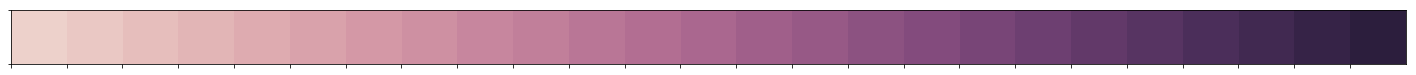

In [111]:
sns.palplot(sns.cubehelix_palette(25))

In [61]:
print(linalg.norm(X))
print(linalg.norm(X - U))
obj = linalg.norm(X - U) / linalg.norm(X)
print(obj)

3140.9046310413655
2792.3900226209585
0.8890400539462234


In [62]:
print(np.var(X))
print(np.var(X - U))
obj = np.var(X - U) / np.var(X)
print(obj)
print((np.var(X) - np.var(X - U)) / np.var(X) )

0.8210453425295249
0.6517949162022779
0.7938598301942615
0.20614016980573846
